In [26]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [123]:
def get_columns_and_types(df):
    print('Types detected:')
    print(df.dtypes.unique())
    return {
        'int': [label for label, dtype in df.dtypes.items() if dtype in [int, np.int64]],
        'float': [label for label, dtype in df.dtypes.items() if dtype in [float, np.float64]],
        'object': [label for label, dtype in df.dtypes.items() if dtype in ['O', 'object']],
    }

def convert_dollars_to_float(s, pattern=r"\$|,"):
    """
    convert money-like strings to floats
    """
    if type(s) is str and re.match(pattern, s):
        # if the input is a str containing '$' and/or ',' try to remove those chars and covert the result to a float
        # if this fails, then there is likely text mixed in (like "$195 this week only!")
        try:
            return float(re.sub(pattern, repl='', string=s))
        except:
            return s
    else:
        # otherwise just return the input
        return s

def estimate_y_from_X(data, y_label, X_labels, train_size=0.6, random_state=42):
    if type(X_labels) not in [list, tuple]:
        X_labels = [X_labels] # in case we pass a scalar
        
    # we know that we have data for 'price' in all observations, but not for 'monthly_price' or 'weekly_price'
    # drop the nans, create a train/test split, build a model and estimate the monthly, then use the model to fill the missing values in the dataset
    reg_data = data[X_labels + [y_label]].dropna()
    y = reg_data[y_label]
    X = sm.add_constant(reg_data[X_labels])
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)

    print(f'Estimating {y_label}~1+{X_labels}')
    m = sm.OLS(exog=X_train, endog=y_train).fit()
    
    print(f'Train fit: {r2_score(y_true=y_train, y_pred=m.predict(exog=X_train))}')
    print(f'Test fit: {r2_score(y_true=y_test, y_pred=m.predict(exog=X_test))}')
    
    print(f'Filling NaNs in {y_label} with estimated data')
    missing = data[y_label][data[y_label].isnull()].index
    data.loc[missing, y_label] = m.predict(exog=sm.add_constant(data[data[y_label].isnull()][X_labels]))
    return data

# Boston Airbnb Dataset
https://www.kaggle.com/datasets/airbnb/boston?resource=download

Possible questions:
- Are there seasonal pattern to the month (or time of time)?
- Is there a seasonal pattern to <time> and location?
- Can we fit a penalized regression model to predict price given <X>?
- Can we show an animated map of Boston, showing average price per zip over time?

In [124]:
boston_listings = pd.read_csv('./data/airbnb_boston/listings.csv', index_col='id')
boston_calendar = pd.read_csv('./data/airbnb_boston/calendar.csv')
boston_reviews = pd.read_csv('./data/airbnb_boston/reviews.csv')

boston_listings = boston_listings.map(convert_dollars_to_float)
boston_calendar = boston_calendar.apply(convert_dollars_to_float)
boston_reviews = boston_reviews.apply(convert_dollars_to_float)

boston_listings = estimate_y_from_X(data=boston_listings, y_label='monthly_price', X_labels='price')
boston_listings = estimate_y_from_X(data=boston_listings, y_label='weekly_price', X_labels='price')

Estimating monthly_price~1+['price']
Train fit: 0.7541200119650564
Test fit: 0.7023480777981016
Filling NaNs in monthly_price with estimated data
Estimating weekly_price~1+['price']
Train fit: 0.8616937710787316
Test fit: 0.8204677405118834
Filling NaNs in weekly_price with estimated data


In [92]:
boston_listing_col_types = get_columns_and_types(boston_listings)
boston_listing_col_types

Types detected:
[dtype('O') dtype('int64') dtype('float64')]


{'int': ['scrape_id',
  'host_id',
  'host_listings_count',
  'host_total_listings_count',
  'accommodates',
  'guests_included',
  'minimum_nights',
  'maximum_nights',
  'availability_30',
  'availability_60',
  'availability_90',
  'availability_365',
  'number_of_reviews',
  'calculated_host_listings_count'],
 'float': ['neighbourhood_group_cleansed',
  'latitude',
  'longitude',
  'bathrooms',
  'bedrooms',
  'beds',
  'square_feet',
  'price',
  'weekly_price',
  'monthly_price',
  'security_deposit',
  'cleaning_fee',
  'extra_people',
  'has_availability',
  'review_scores_rating',
  'review_scores_accuracy',
  'review_scores_cleanliness',
  'review_scores_checkin',
  'review_scores_communication',
  'review_scores_location',
  'review_scores_value',
  'license',
  'jurisdiction_names',
  'reviews_per_month'],
 'object': ['listing_url',
  'last_scraped',
  'name',
  'summary',
  'space',
  'description',
  'experiences_offered',
  'neighborhood_overview',
  'notes',
  'transit'

# there are no empty 'price' values, but there are empty weekly_price/monthly_price values
- We can ignore weekly_price/monthly_price and just work with price, or we can estimate the missing values with regression

In [93]:
boston_listings[['price', 'weekly_price', 'monthly_price', 'zipcode']].dropna().groupby('zipcode').mean().sort_values('price')

,price,weekly_price,monthly_price
zipcode,,,
02124,67.235294,369.411765,1141.764706
02125,86.395833,600.541667,1798.562500
02131,86.520000,534.120000,1696.960000
02126,90.777778,565.111111,1829.444444
02136,91.375000,550.875000,2018.750000
02134,91.590164,569.852459,1960.114754
02122,92.166667,581.833333,1910.083333
02445,92.500000,457.500000,1697.500000
02120,104.136364,751.045455,2343.954545


In [94]:
boston_calendar_col_types = get_columns_and_types(boston_calendar)
boston_calendar_col_types

Types detected:
[dtype('int64') dtype('O')]


{'int': ['listing_id'], 'float': [], 'object': ['date', 'available', 'price']}

In [95]:
boston_review_col_types = get_columns_and_types(boston_reviews)
boston_review_col_types

Types detected:
[dtype('int64') dtype('O')]


{'int': ['listing_id', 'id', 'reviewer_id'],
 'float': [],
 'object': ['date', 'reviewer_name', 'comments']}

In [96]:
boston_listings[boston_listing_col_types['int']].sort_index()

,scrape_id,host_id,host_listings_count,host_total_listings_count,accommodates,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,calculated_host_listings_count
id,,,,,,,,,,,,,,
3353,20160906204935,4240,6,6,1,1,7,365,0,0,0,249,34,2
5506,20160906204935,8229,7,7,2,2,3,730,14,39,69,344,36,6
6695,20160906204935,8229,7,7,4,2,3,730,3,19,49,324,47,6
6976,20160906204935,16701,1,1,2,1,3,45,19,46,61,319,41,1
8792,20160906204935,26988,12,12,3,0,30,365,0,0,0,248,18,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14924831,20160906204935,93820834,1,1,1,1,1,14,6,36,66,66,0,1
14928000,20160906204935,93854106,1,1,1,1,1,1125,30,60,90,365,0,1
14928333,20160906204935,36238029,1,1,2,1,1,1125,11,34,64,339,0,1


Train fit: 0.9325335402955914
Test fit: 0.9677777052053934


In [ ]:
boston_listings[boston_listing_col_types['float']].sort_index().dropna(how='all', axis=1)

<Axes: xlabel='square_feet', ylabel='price'>

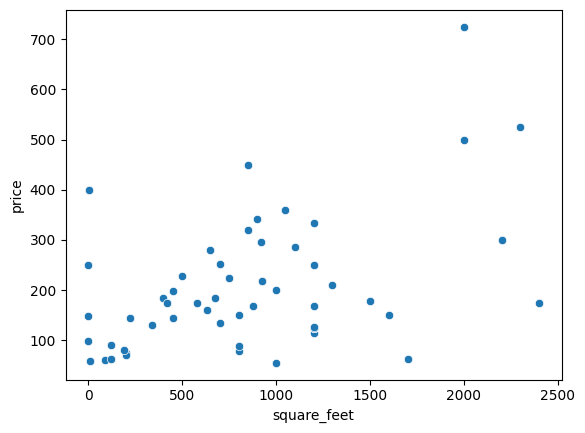

In [12]:
sns.scatterplot(
    data=boston_listings[['price', 'square_feet']].dropna(),
    x='square_feet', y='price')

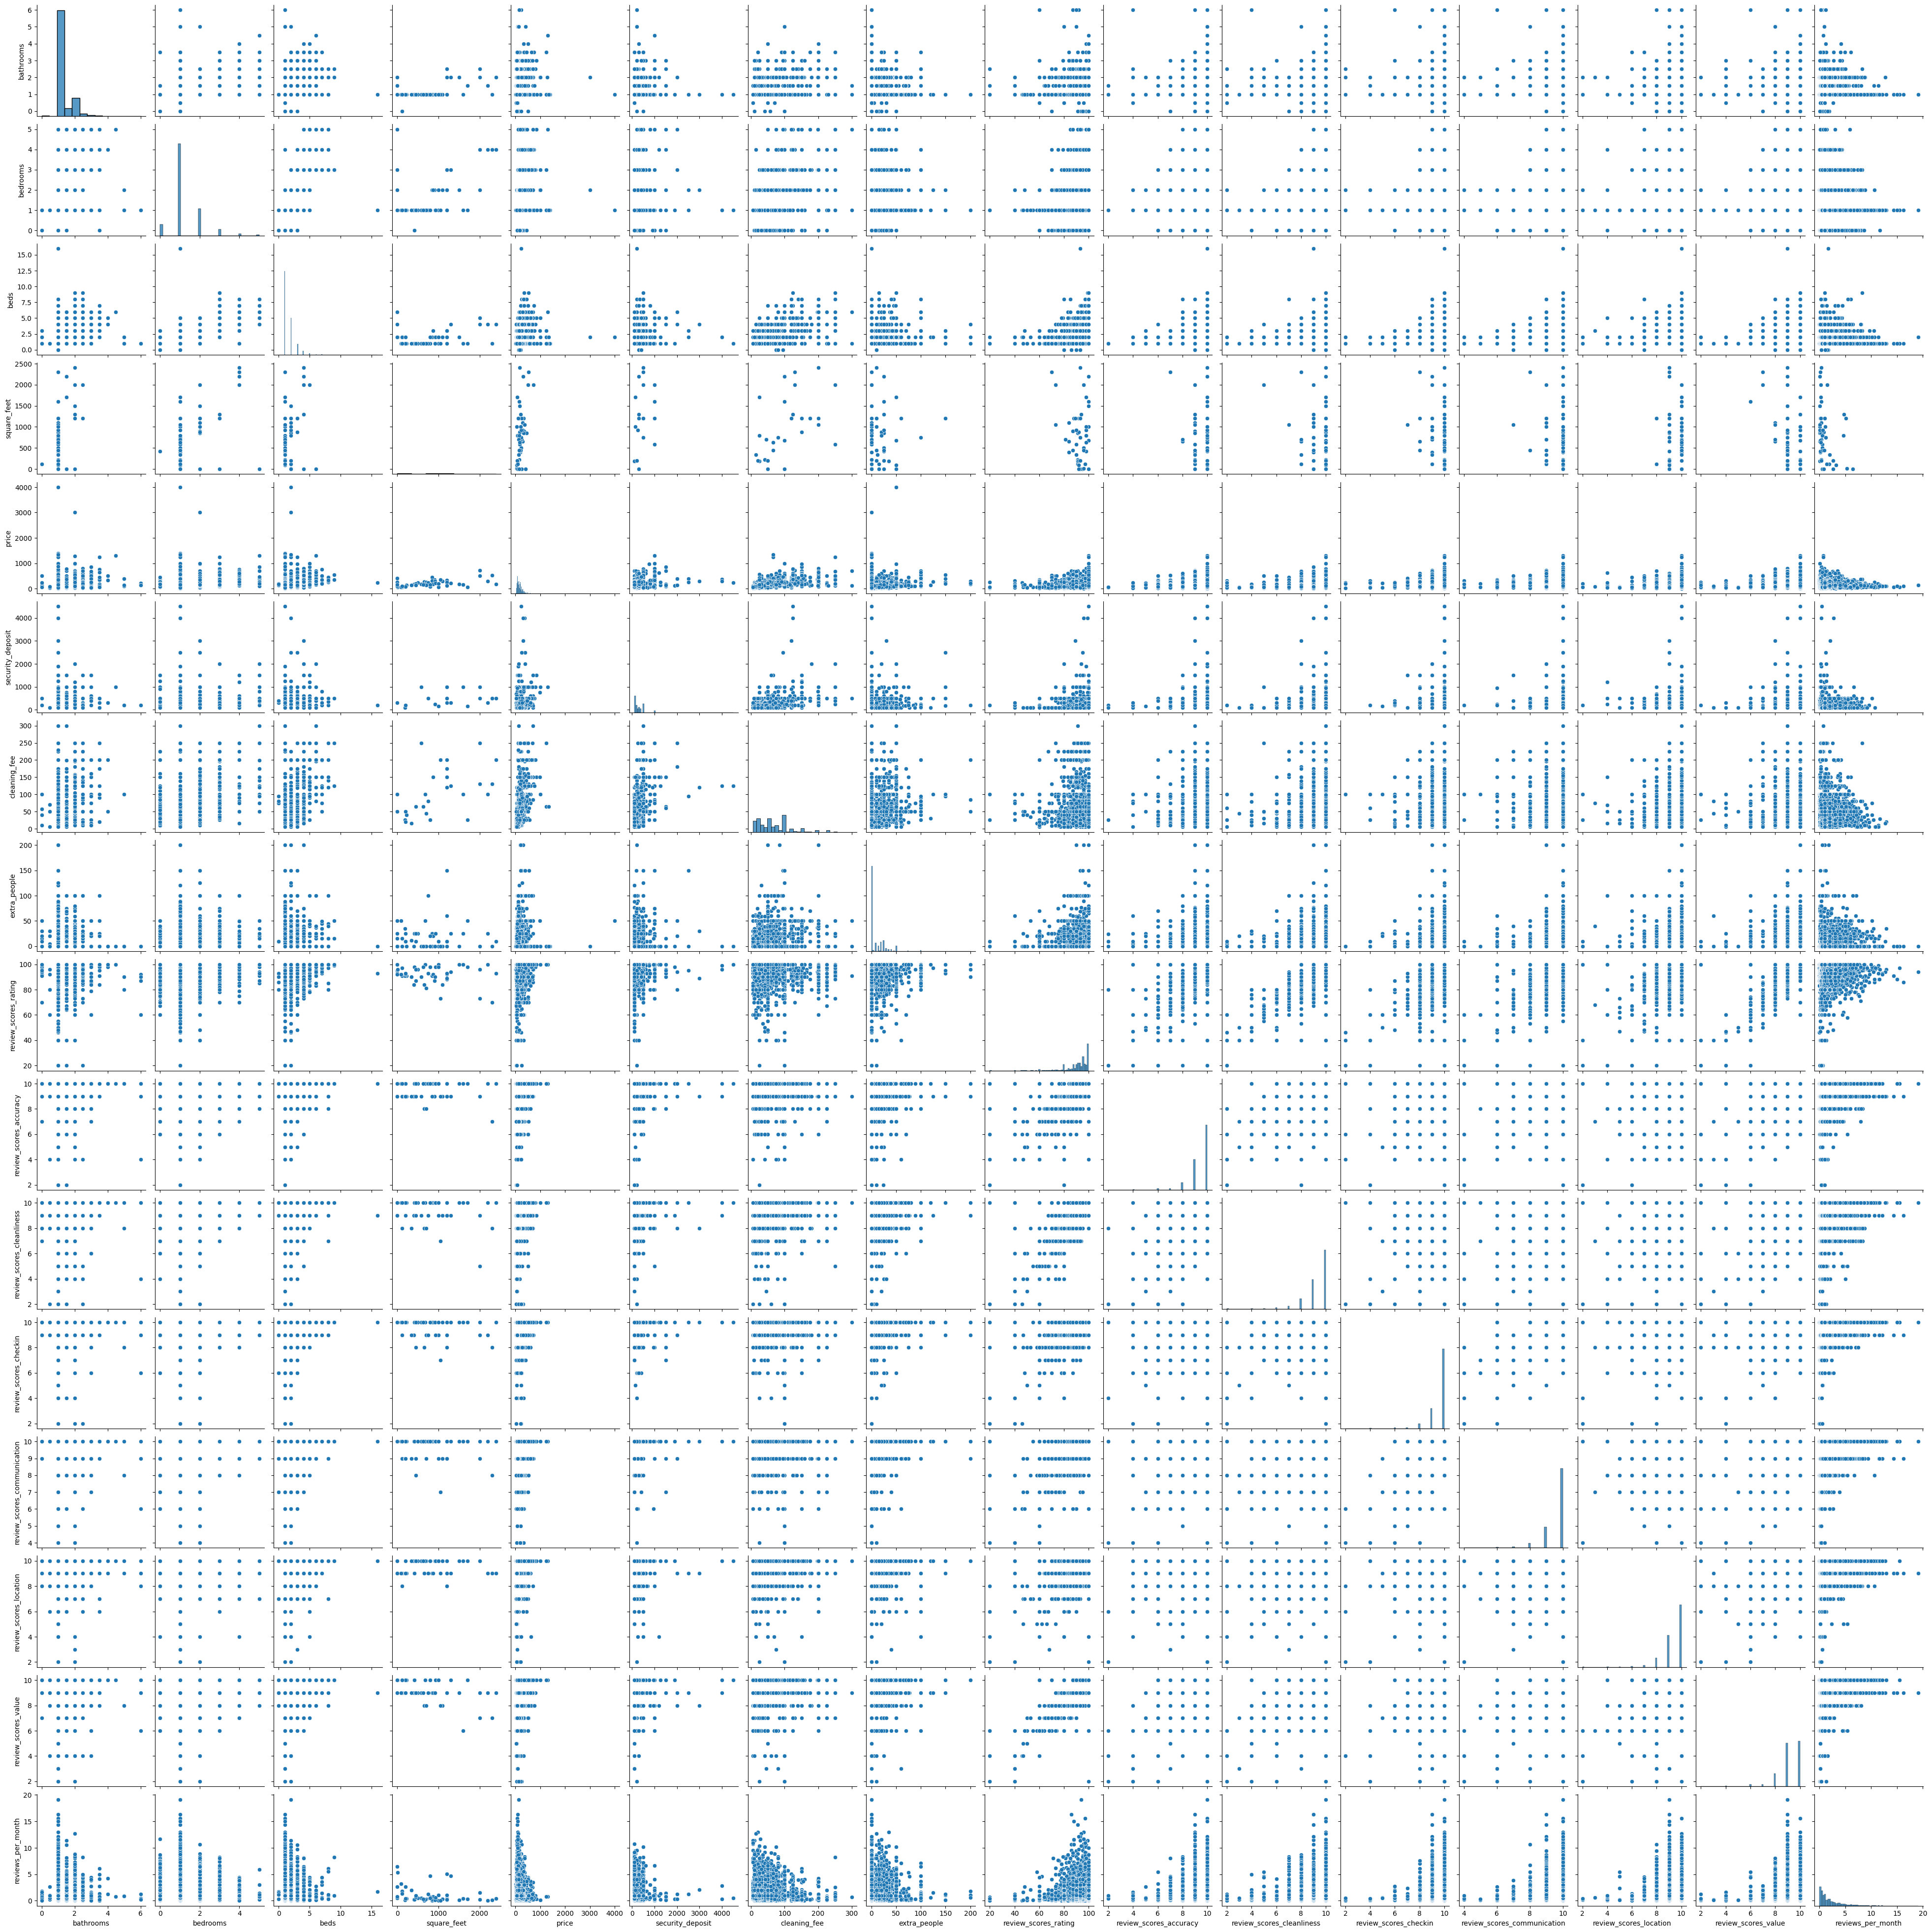

In [13]:
sns.pairplot(
    boston_listings[boston_listing_col_types['float']].sort_index().dropna(how='all', axis=1) \
        .drop(['latitude', 'longitude', 'weekly_price', 'monthly_price'], axis=1)
)

In [ ]:
boston_calendar[boston_calendar.price.isnull()]

In [ ]:
boston_calendar[boston_calendar.price.notnull()]

In [ ]:
# convert price column to a float, assuming format of $#.#
boston_calendar.price = [float(i.replace('$', '').replace(',', '')) if type(i) is str else i for i in boston_calendar.price]

# concert date to a datetime object
boston_calendar.date = [pd.Timestamp(i) if type(i) is str else i for i in boston_calendar.date]

# add a month, year columns for seasonality analysis
boston_calendar['month'] = [i.month for i in boston_calendar.date]
boston_calendar['year'] = [i.year for i in boston_calendar.date]

In [ ]:
sns.boxplot(
    data=boston_calendar.dropna(),
    x='month',
    y='price',
)

# Seattle Airbnb Dataset
https://www.kaggle.com/datasets/airbnb/seattle/data

In [ ]:
seattle_listings = pd.read_csv('./data/airbnb_seattle/listings.csv', index_col='id')

In [ ]:
seattle_col_types = get_columns_and_types(seattle_listings)

# Stackoverflow Survey Dataset
https://www.kaggle.com/datasets/stackoverflow/so-survey-2017